Risa and I discussed one figure that shows all results for all tests. The proposal was an image that shows how far the true value deviates from the posterior peak in terms of standard deviations for the key params. It'll take some tinkering but we should be able to find something that works. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict

In [3]:
fnames = []
models = ['HOD_2', 'HSAB_2', 'CAB_2', 'CorrAB_3']
mocks = ['HOD_MDPL2', 'HSAB_MDPL2', 'VpeakSHAM', 'UniverseMachine']

mock_no = 3

for mock in mocks[mock_no:mock_no+1]:
    for model in models:
        fn = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/%s_wp_ds_rmin_*_%s.hdf5'%(mock,model))) 
        # put the None chain first instead of last 
        
        _fnames = []
        _fnames.extend(reversed(fn[:-1]) )
        _fnames.append(fn[-1])
        fn = _fnames

        fnames.extend(fn)

Assume all chains run with same true values, only thing that differs is the rmin. 

In [4]:
names_to_remove = []
for fname in fnames:
    if '2.0' in fname:
        names_to_remove.append(fname)
    #pass    
for fname in names_to_remove:
    fnames.remove(fname)

In [5]:
f = h5py.File(fnames[0], 'r')

In [6]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [7]:
#sim_info = eval(f.attrs['sim'])
sim_info = f.attrs['sim']

In [8]:
f.close()

In [9]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$','sigma_logM': r'$\sigma_{\log M }$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$',
                  'Om': r'$\Omega_m$', 'S8': r'$S_8$'}

In [10]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
 'Neff': (2.62125, 4.27875),
 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
 'logM0': (12.6, 13.6),
 'logM1': (13.7, 14.7),
 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997),
 'sigma_logM': (0.05, 0.5),
 'ln10As': (3.0, 3.1),
 'w0': (-1.399921, -0.5658486),
 'Om': (0.25, 0.35),
 'S8': (0.7, 1.0),
 'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [11]:
# multidark planck2
#cosmo_true_vals = np.array([0.0223, 0.1188, -1, 0.9667, 3.047, \
#                            0.6774*100, 3.046]) #darksky

h = 0.6777
#cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'Om', 'S8']
#cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2- 0.048206*h**2,\
#                            -1, 0.9667, \
#                            h*100, 3.046, 0.8228, ]) #mdpl2
cosmo_true_vals = np.array([0.048206*h**2, 0.2589*h**2- 0.048206*h**2,\
                        -1, 0.9667, \
                        h*100, 3.046, 0.8228, 0.3089, 0.8228*np.sqrt(0.3089/0.3) ]) #mdpl2
#hod_true_vals = np.array([np.inf for p in hod_param_names])
Om = 0.3089
S8 = 0.8228*np.sqrt(0.3089/0.3)
H0=h*100

In [12]:
summary_names = ['Om','S8','H0']
true_vals_dict = dict(zip(summary_names, [Om, S8, H0]))
def_ab_val = np.inf#0.0

In [13]:
c = ChainConsumer()

In [14]:
def modify_chain(chain, param_names):
    new_pnames = ['Om', 'S8']
    h = chain[:,param_names.index('H0')]/100
    
    Omc, Omb = chain[:,param_names.index('omch2')]/(h**2), chain[:,param_names.index('ombh2')]/(h**2)
    Om = Omc+Omb
    
    S8 = chain[:,param_names.index('sigma8')]*np.sqrt(Om/0.3)

    new_chain = np.hstack([chain[:,:7], Om.reshape((-1,1)), S8.reshape((-1,1)), chain[:,7:]])
    param_names.insert(7, new_pnames[0])
    param_names.insert(8, new_pnames[1])

    return new_chain, param_names

In [15]:
f = h5py.File(fname, 'r')

In [16]:
r = np.logspace(-1, 1.6, 19)
rbc = (r[1:]+r[:-1])/2.0

In [17]:
num_eff_dict = {5.0:np.sum(rbc>5.0)*2, 1.0:np.sum(rbc>1.0)*2, 0.5:np.sum(rbc>0.5)*2,\
0.1:np.sum(rbc>0.5)+np.sum(rbc>0.1)}

In [18]:
n_burn = 10000
plot_true_vals_dict = dict()
plot_bounds_dict = dict()
plot_param_names_set = set()
for fname in fnames:
    try:
        f = h5py.File(fname, 'r')
        n_walkers = f.attrs['nwalkers']

        chain = f['chain'][n_burn*n_walkers:]
        lnprob = f['lnprob'][n_burn*n_walkers:]
        keep_idxs = np.all(chain!=0.0, axis = 1)
        chain = chain[keep_idxs, :]
        lnprob = lnprob[keep_idxs]
    except IOError:
        print 'Error loading', fname
        #f.close()
        chain = np.random.randn(n_walkers, chain.shape[1])+10
        lnprob = np.ones((chain.shape[0],))*-np.inf
        #continue
    
    chain = chain.reshape((-1, n_walkers, chain.shape[1]))
    chain = chain.reshape((-1, chain.shape[2]), order = 'F')
    if chain.shape[0] == 0:
        print 'Insufficient samples in', fname
        #f.close()
        chain = np.random.randn(n_walkers, chain.shape[1])+10
        lnprob = np.zeros((chain.shape[0],))
        #continue
    
    #name = path.basename(fname).split('_')[-1].split('.')[0]
    split_fname = path.basename(fname).split('_')#[4]
    r = split_fname[-3] #[4]
    model = split_fname[-2]#[:-5]#[5]
    mock = split_fname[0]
    
    #print r, model, mock
    #break

    if r == "None":
        r = "0.1"
        
    name = r"%s %s $r_{min} = %s"%(mock, model, r)
    
    hod_param_names = []
    cosmo_param_names = []
    chain_pnames = list(f.attrs['param_names'])
    #cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'Om', 'S8'])
    chain, chain_pnames = modify_chain(chain, chain_pnames)
    summary_idxs = []
    param_names = []
    for i, pname in enumerate(chain_pnames):
        if pname in summary_names:# or ('mean_occupation' in pname and 'slope' not in pname):
            param_names.append(param_name_dict[pname])
            summary_idxs.append(i)
            plot_true_vals_dict[param_names[-1]] = true_vals_dict[pname] if pname in true_vals_dict else def_ab_val
            plot_bounds_dict[param_names[-1]] = bounds_dict[pname] 
            plot_param_names_set.add(param_names[-1])
    #print fname
    if chain.shape[0]/n_walkers > 50000:
        chain = chain[:50000*n_walkers]
        lnprob = lnprob[:50000*n_walkers]
    #print summary_idxs, param_names
    print name
    print chain.shape, chain.shape[0]/n_walkers, len(param_names)
    
    c.add_chain(chain[:, np.array(summary_idxs)], parameters=param_names,
                name = name, walkers = n_walkers, posterior = lnprob,
               num_eff_data_points = num_eff_dict[float(r)], num_free_params = len(param_names))
    f.close()


UniverseMachine HOD $r_{min} = 5.0
(12500000, 14) 50000 3
UniverseMachine HOD $r_{min} = 1.0
(12500000, 14) 50000 3
UniverseMachine HOD $r_{min} = 0.5
(12500000, 14) 50000 3
UniverseMachine HOD $r_{min} = 0.1
(12500000, 14) 50000 3
UniverseMachine HSAB $r_{min} = 5.0
(12500000, 16) 50000 3
UniverseMachine HSAB $r_{min} = 1.0
(12500000, 16) 50000 3
UniverseMachine HSAB $r_{min} = 0.5
(12500000, 16) 50000 3
UniverseMachine HSAB $r_{min} = 0.1
(12500000, 16) 50000 3
UniverseMachine CAB $r_{min} = 5.0
(12500000, 18) 50000 3
UniverseMachine CAB $r_{min} = 1.0
(12500000, 18) 50000 3
UniverseMachine CAB $r_{min} = 0.5
(12500000, 18) 50000 3
UniverseMachine CAB $r_{min} = 0.1
(12500000, 18) 50000 3
UniverseMachine CorrAB $r_{min} = 5.0
(12500000, 16) 50000 3
UniverseMachine CorrAB $r_{min} = 1.0
(12500000, 16) 50000 3
UniverseMachine CorrAB $r_{min} = 0.5
(12500000, 16) 50000 3
UniverseMachine CorrAB $r_{min} = 0.1
(12500000, 16) 50000 3


In [19]:
from scipy.linalg import inv, det

In [20]:
try:
    dist_mat=np.load('dist_mat.npy')
except IOError:
    #pass  
    dist_mat = np.zeros((4,4,4))
rmins = [5.0, 1.0, 0.5, 0.1]

In [21]:
true_point = np.array([true_vals_dict[name] for name in sorted(summary_names)])
print true_point
print '-'*10
models = ['HOD', 'HSAB', 'CAB', 'CorrAB']
mocks = ['HOD', 'HSAB', 'VpeakSHAM', 'UniverseMachine']
base_str = '%s %s $r_{min} = %0.1f'
for i, mock in enumerate(mocks[mock_no:mock_no+1]):
    print mock
    for j, model in enumerate(models):
        print model
        for k, rmin in enumerate(rmins):
            chain_name = base_str%(mock, model, rmin)
            #print chain_name
            #print c.chains[0].name
            names, cov = c.analysis.get_covariance(chain_name)
            #print cov
            inv_cov = inv(cov)

            #max_dict = c.analysis.get_max_posteriors(chains=chain_name)
            #max_point = np.array([max_dict[name] for name in names])
            max_dict = c.analysis.get_summary(chains = chain_name)
            max_point = np.array([max_dict[name][1] for name in names])

            delta = true_point-max_point
            d2 = delta.T.dot(inv_cov.dot(delta))
            true_d = np.sqrt(d2)
            print cov
        
            print true_d
            print c.chains[j*4+k].name, chain_name
            all_points = c.chains[j*4+k].chain#[:,idxs]
            all_delta = (all_points-max_point)#[:1000]
            all_d2 = np.array([d.T.dot(inv_cov.dot(d)) for d in all_delta])
            all_d = np.sqrt(all_d2)
            #print max_point
            dist_mat[i+mock_no,j,k] = np.sum(true_d<all_d)*1.0/all_d.shape[0]#np.sqrt(d2)
            #print chain_name,  np.sqrt(d2)#, likelihood(cov, d2)
            #print 

[67.77        0.3089      0.83491567]
----------
UniverseMachine
HOD
[[ 7.20915479e+00 -4.53940883e-02  4.24873451e-02]
 [-4.53940883e-02  3.56576685e-04 -3.25078959e-04]
 [ 4.24873451e-02 -3.25078959e-04  1.38952710e-03]]
1.3840075974209263
UniverseMachine HOD $r_{min} = 5.0 UniverseMachine HOD $r_{min} = 5.0
[[ 5.67048809e+00 -3.52717350e-02  2.31603489e-02]
 [-3.52717350e-02  2.86781283e-04 -1.74185701e-04]
 [ 2.31603489e-02 -1.74185701e-04  6.05024430e-04]]
1.3388566007205642
UniverseMachine HOD $r_{min} = 1.0 UniverseMachine HOD $r_{min} = 1.0
[[ 5.13126256e+00 -3.07526188e-02  1.78612701e-02]
 [-3.07526188e-02  2.53793641e-04 -1.43402585e-04]
 [ 1.78612701e-02 -1.43402585e-04  5.51839255e-04]]
1.282071391182042
UniverseMachine HOD $r_{min} = 0.5 UniverseMachine HOD $r_{min} = 0.5
[[ 4.90658719e+00 -2.98658158e-02  1.57663495e-02]
 [-2.98658158e-02  2.49512181e-04 -1.26906818e-04]
 [ 1.57663495e-02 -1.26906818e-04  4.06670020e-04]]
1.5751211850159275
UniverseMachine HOD $r_{min} =

In [22]:
np.save('dist_mat.npy', dist_mat)

In [23]:
dist_mat[1]

array([[0.563266  , 0.92795752, 0.420704  , 0.29244352],
       [0.22234176, 0.77025576, 0.92309032, 0.82421664],
       [0.61937624, 0.93214352, 0.80748688, 0.77256592],
       [0.19210456, 0.46489728, 0.12617744, 0.13041104]])

In [24]:
import seaborn as sns
cmap = sns.diverging_palette(220, 20, n=3, as_cmap=True)

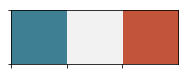

In [25]:
sns.palplot(sns.diverging_palette(220, 20, n=3))

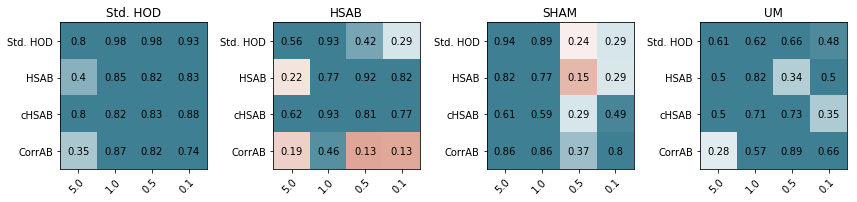

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

fig, axes = plt.subplots(1,4, figsize = (12,6))
floor = 0

mocks = ['Std. HOD', 'HSAB', 'SHAM', 'UM']
models = ['Std. HOD', 'HSAB', 'cHSAB', 'CorrAB']
for mock, d, ax in zip(mocks, dist_mat, axes.flatten()):
    ax.set_title(mock)
    im = ax.imshow(1-d, vmin = 0.5, vmax = 1.0, cmap = cmap)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(rmins)))
    ax.set_yticks(np.arange(len(models)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(rmins)
    ax.set_yticklabels(models)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(rmins)):
        for j in range(len(models)):
            if d[i,j] < floor:
                ax.text(j, i, r'$< %d \sigma$'%floor,
                           ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, round(d[i, j],2),
                           ha="center", va="center", color="k")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
#plt.show()
plt.savefig('key_plot.pdf', format='pdf')

In [ ]:
summary_pnames = list(plot_param_names_set)
summary_true_vals = [plot_true_vals_dict[pname] for pname in summary_pnames]
summary_bounds = [plot_bounds_dict[pname] for pname in summary_pnames]